### https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = [16, 8]
rcParams['font.family'] = ['sans-serif']
rcParams['axes.unicode_minus'] = False 

In [4]:
from matplotlib.font_manager import _rebuild
_rebuild()

In [5]:
training_set = pd.read_csv('airline-passengers.csv')
training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values
training_set = training_set # / training_set.max() * 100

#####
n = 10000
x = np.linspace(0, 100, n)
training_set = np.sin(x) + 1
training_set = training_set + np.cumsum(np.random.randn(n)) / np.sqrt(n) * 99
training_set = training_set.reshape(n, 1)

#####
# # training_set = np.cumsum(np.random.randn(n)) / np.sqrt(n)
# training_set = np.cumsum(np.random.randn(n)) / np.log(n)
# training_set = training_set.reshape(n, 1)

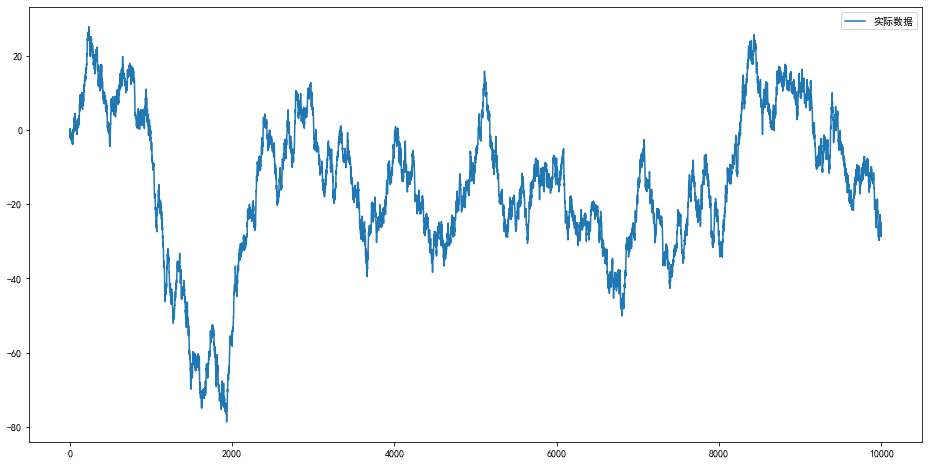

In [6]:
plt.plot(training_set, label = '实际数据')
plt.legend()

In [7]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 8
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.50)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[:train_size])))
trainY = Variable(torch.Tensor(np.array(y[:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:])))
testY = Variable(torch.Tensor(np.array(y[train_size:])))

In [8]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [9]:

num_epochs = 3000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05116
Epoch: 100, loss: 0.00061
Epoch: 200, loss: 0.00031
Epoch: 300, loss: 0.00022
Epoch: 400, loss: 0.00018
Epoch: 500, loss: 0.00015
Epoch: 600, loss: 0.00014
Epoch: 700, loss: 0.00013
Epoch: 800, loss: 0.00012
Epoch: 900, loss: 0.00012
Epoch: 1000, loss: 0.00011
Epoch: 1100, loss: 0.00011
Epoch: 1200, loss: 0.00010
Epoch: 1300, loss: 0.00010
Epoch: 1400, loss: 0.00010
Epoch: 1500, loss: 0.00010
Epoch: 1600, loss: 0.00010
Epoch: 1700, loss: 0.00010
Epoch: 1800, loss: 0.00009
Epoch: 1900, loss: 0.00009
Epoch: 2000, loss: 0.00009
Epoch: 2100, loss: 0.00009
Epoch: 2200, loss: 0.00009
Epoch: 2300, loss: 0.00009
Epoch: 2400, loss: 0.00010
Epoch: 2500, loss: 0.00009
Epoch: 2600, loss: 0.00009
Epoch: 2700, loss: 0.00009
Epoch: 2800, loss: 0.00009
Epoch: 2900, loss: 0.00009


In [10]:
lstm.eval()

LSTM(
  (lstm): LSTM(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [11]:
pres = []
pre = None
for i in range(testX.shape[0]):
    if pre is None:
        pre = lstm(testX[i].reshape(1, seq_length, 1))
    else:
        d = testX[i]
        d[-1] = pre.item()
        pre = lstm(d.reshape(1, seq_length, 1))
    pres.append(pre.item())
    
dp = sc.inverse_transform(np.asarray(pres).reshape(testX.shape[0], 1))
xpd = np.asarray(range(train_size, train_size + test_size))

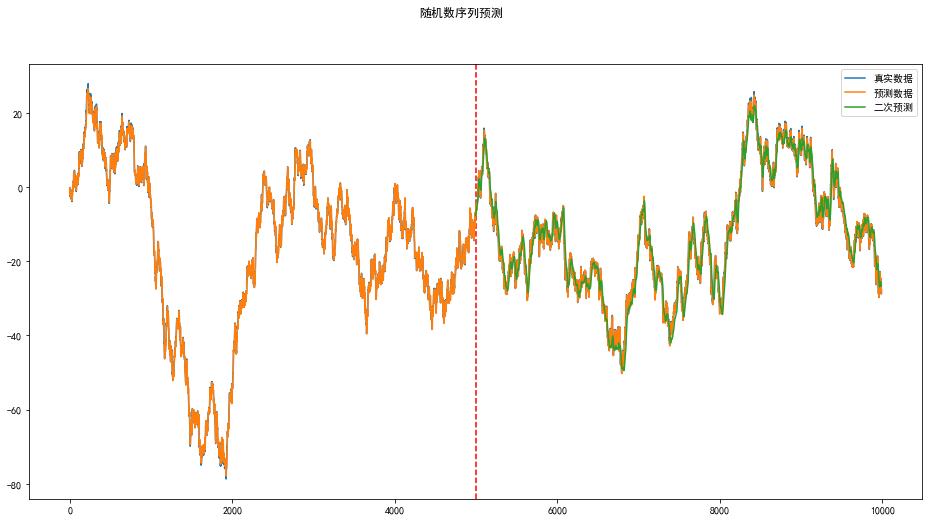

In [12]:
train_predict = lstm(dataX)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label='真实数据')
plt.plot(data_predict, label='预测数据')
plt.plot(xpd, dp, label='二次预测')
plt.suptitle('随机数序列预测')
plt.legend()
plt.show()